Columns in the DataFrame: Index(['title', 'text', 'subject', 'date', 'target'], dtype='object')

Logistic Regression (N-grams) Evaluation Metrics:
Training Accuracy: 0.9785732853058041
Testing Accuracy: 0.9757157179458616
Precision: 0.9819121447028424
Recall: 0.9714529186195143
F1 Score: 0.9766545298779182
Confusion Matrix:
 [[4199   84]
 [ 134 4560]]


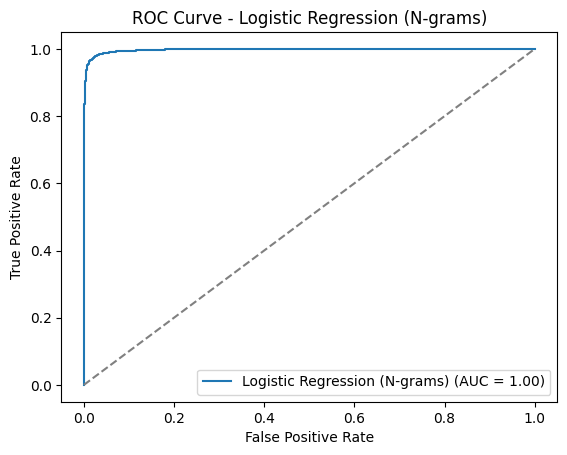


Random Forest (N-grams) Evaluation Metrics:
Training Accuracy: 0.9994058449998143
Testing Accuracy: 0.9974378968474992
Precision: 0.9985058697972252
Recall: 0.9965913932680017
F1 Score: 0.997547712975797
Confusion Matrix:
 [[4276    7]
 [  16 4678]]


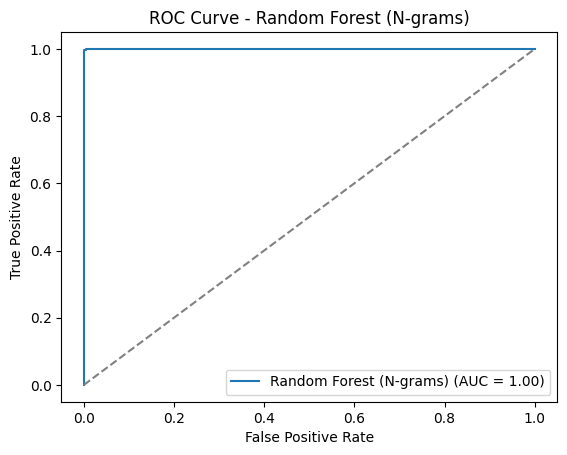


Gradient Boosting (N-grams) Evaluation Metrics:
Training Accuracy: 0.9968435515615136
Testing Accuracy: 0.9963239389551075
Precision: 0.9985026737967915
Recall: 0.9944610140605028
F1 Score: 0.9964777457572846
Confusion Matrix:
 [[4276    7]
 [  26 4668]]


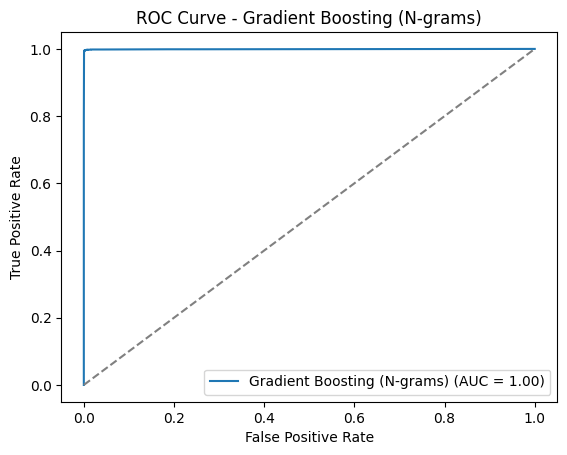

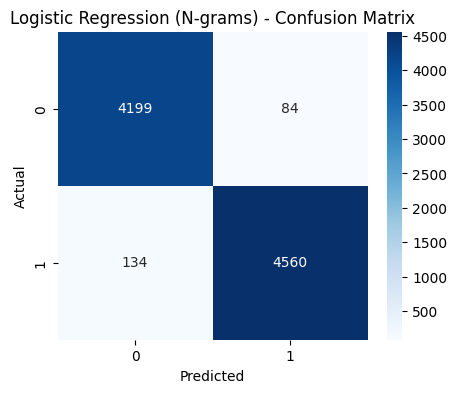

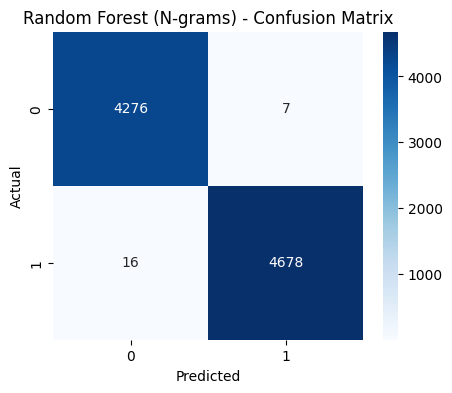

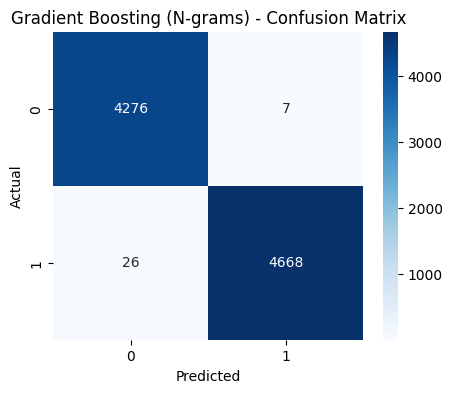

Epoch: 01 | Train Loss: 0.529 | Train Acc: 75.38% | Val Loss: 0.371 | Val Acc: 86.90%
Epoch: 02 | Train Loss: 0.470 | Train Acc: 79.15% | Val Loss: 0.454 | Val Acc: 78.61%
Epoch: 03 | Train Loss: 0.321 | Train Acc: 87.55% | Val Loss: 0.205 | Val Acc: 93.33%
Epoch: 04 | Train Loss: 0.234 | Train Acc: 91.82% | Val Loss: 0.169 | Val Acc: 95.39%
Epoch: 05 | Train Loss: 0.057 | Train Acc: 98.37% | Val Loss: 0.027 | Val Acc: 99.41%
Epoch: 06 | Train Loss: 0.020 | Train Acc: 99.53% | Val Loss: 0.014 | Val Acc: 99.66%
Epoch: 07 | Train Loss: 0.016 | Train Acc: 99.62% | Val Loss: 0.020 | Val Acc: 99.60%
Epoch: 08 | Train Loss: 0.036 | Train Acc: 99.18% | Val Loss: 0.022 | Val Acc: 99.59%
Epoch: 09 | Train Loss: 0.029 | Train Acc: 99.34% | Val Loss: 0.019 | Val Acc: 99.45%
Epoch: 10 | Train Loss: 0.052 | Train Acc: 98.42% | Val Loss: 0.070 | Val Acc: 97.93%

PyTorch LSTM Evaluation Metrics:
Testing Accuracy: 0.9811741116185808
Precision: 0.975015746378333
Recall: 0.9893481039625053
F1 Score: 0.9

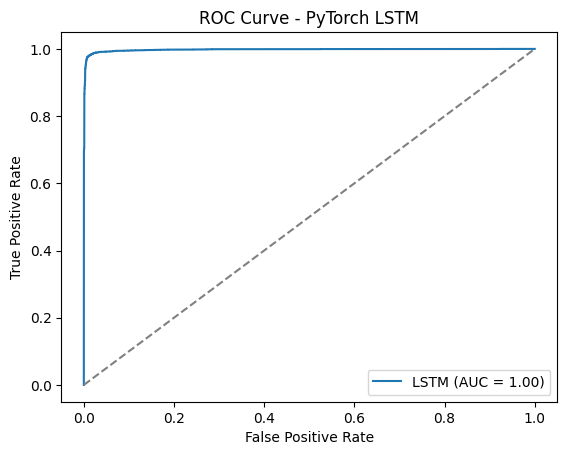

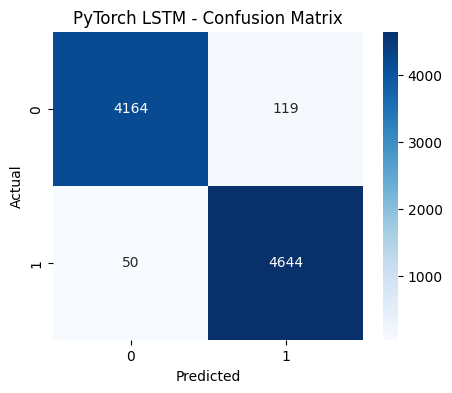

In [ ]:
import re, string, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder


np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    words = [w for w in text.split() if w not in stop_words]
    return ' '.join(lemmatizer.lemmatize(w) for w in words)


try:
    df = pd.read_csv('C:/Users/Abdelrahman Ahmed/Downloads/fake_real_news.csv')
 
    print("Columns in the DataFrame:", df.columns)

    LABEL_COLUMN = 'target'

    if LABEL_COLUMN in df.columns:
        df['label'] = df[LABEL_COLUMN].astype(int)
        df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
        df = df[['title', 'text', 'content', 'label']]
    else:
        raise KeyError(f"Column '{LABEL_COLUMN}' not found in the CSV file. Please check the column names and update the LABEL_COLUMN variable accordingly.")

except FileNotFoundError:
    print("Error: 'C:/Users/Abdelrahman Ahmed/Downloads/fake_real_news.csv' not found. Please make sure the file path is correct.")
    exit()
except KeyError as e:
    print(f"Error: {e}")
    exit()

df['cleaned_content'] = df['content'].apply(preprocess)
df = df[df['cleaned_content'].str.split().str.len() > 5]

X = df['cleaned_content'] 
y = df['label']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)


X_train = X_train.fillna('')
X_val = X_val.fillna('')
X_test = X_test.fillna('')

# N-gram TF-IDF Vectorizer for traditional models
ngram_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = ngram_tfidf.fit_transform(X_train)
X_val_tfidf = ngram_tfidf.transform(X_val)
X_test_tfidf = ngram_tfidf.transform(X_test)

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    test_probs = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Evaluation Metrics:")
    print("Training Accuracy:", accuracy_score(y_train, train_preds))
    print("Testing Accuracy:", accuracy_score(y_test, test_preds))
    print("Precision:", precision_score(y_test, test_preds))
    print("Recall:", recall_score(y_test, test_preds))
    print("F1 Score:", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))

    fpr, tpr, _ = roc_curve(y_test, test_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

# Logistic Regression
log_model = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)
evaluate_model("Logistic Regression (N-grams)", log_model, X_train_tfidf, y_train, X_test_tfidf, y_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=5, min_samples_leaf=3, max_features='sqrt', random_state=42)
evaluate_model("Random Forest (N-grams)", rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
evaluate_model("Gradient Boosting (N-grams)", gb_model, X_train_tfidf, y_train, X_test_tfidf, y_test)

def plot_confusion_matrix(model_name, y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels if labels else sorted(y.unique()),
                yticklabels=labels if labels else sorted(y.unique()))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

# Plot confusion matrices for traditional models
plot_confusion_matrix("Logistic Regression (N-grams)", y_test, log_model.predict(X_test_tfidf))
plot_confusion_matrix("Random Forest (N-grams)", y_test, rf_model.predict(X_test_tfidf))
plot_confusion_matrix("Gradient Boosting (N-grams)", y_test, gb_model.predict(X_test_tfidf))



# Tokenizer for PyTorch
def build_vocabulary(texts, max_words=50000):
    word_counts = {}
    for text in texts:
        for word in text.split():
            word_counts[word] = word_counts.get(word, 0) + 1
    sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
    vocabulary = {word: index + 2 for index, word in enumerate(sorted_words[:max_words - 2])}
    vocabulary['<PAD>'] = 0
    vocabulary['<UNK>'] = 1
    return vocabulary

vocabulary = build_vocabulary(X_train, max_words=50000)
vocab_size = len(vocabulary)
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

def text_to_sequence(text, vocabulary, max_len):
    sequence = [vocabulary.get(word, 1) for word in text.split()]
    padded_sequence = sequence[:max_len] + [0] * max(0, max_len - len(sequence))
    return padded_sequence

X_train_seq = [text_to_sequence(text, vocabulary, MAX_SEQUENCE_LENGTH) for text in X_train]
X_val_seq = [text_to_sequence(text, vocabulary, MAX_SEQUENCE_LENGTH) for text in X_val]
X_test_seq = [text_to_sequence(text, vocabulary, MAX_SEQUENCE_LENGTH) for text in X_test]

y_train_torch = torch.tensor(y_train.values, dtype=torch.long)
y_val_torch = torch.tensor(y_val.values, dtype=torch.long)
y_test_torch = torch.tensor(y_test.values, dtype=torch.long)

X_train_torch = torch.tensor(X_train_seq, dtype=torch.long)
X_val_torch = torch.tensor(X_val_seq, dtype=torch.long)
X_test_torch = torch.tensor(X_test_seq, dtype=torch.long)

class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = NewsDataset(X_train_torch, y_train_torch)
val_dataset = NewsDataset(X_val_torch, y_val_torch)
test_dataset = NewsDataset(X_test_torch, y_test_torch)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        # Use the final hidden state of the last layer
        hidden = self.dropout(hidden[-1, :, :])
        return self.fc(hidden)

hidden_dim = 100
output_dim = 2
dropout = 0.3

torch_lstm_model = LSTMModel(vocab_size, EMBEDDING_DIM, hidden_dim, output_dim, dropout)
optimizer = optim.Adam(torch_lstm_model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch_lstm_model = torch_lstm_model.to(device)
criterion = criterion.to(device)

def train_torch_model(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, labels = batch
        text = text.to(device)
        labels = labels.to(device)
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = (predictions.argmax(dim=1) == labels).float().mean()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_torch_model(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text = text.to(device)
            labels = labels.to(device)
            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = (predictions.argmax(dim=1) == labels).float().mean()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

n_epochs = 10
for epoch in range(n_epochs):
    train_loss, train_acc = train_torch_model(torch_lstm_model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate_torch_model(torch_lstm_model, val_loader, criterion)
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.2f}%')

def get_predictions(model, iterator):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text = text.to(device)
            output = model(text)
            preds = output.argmax(dim=1).cpu().numpy()
            labels = labels.cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels)
    return np.array(predictions), np.array(true_labels)

torch_test_preds, torch_test_true = get_predictions(torch_lstm_model, test_loader)

print("\nPyTorch LSTM Evaluation Metrics:")
print("Testing Accuracy:", accuracy_score(torch_test_true, torch_test_preds))
print("Precision:", precision_score(torch_test_true, torch_test_preds))
print("Recall:", recall_score(torch_test_true, torch_test_preds))
print("F1 Score:", f1_score(torch_test_true, torch_test_preds))
print("Confusion Matrix:\n", confusion_matrix(torch_test_true, torch_test_preds))

# ROC Curve for PyTorch LSTM
probabilities = nn.functional.softmax(torch_lstm_model(X_test_torch.to(device)), dim=1).cpu().detach().numpy()[:, 1]
fpr_lstm_torch, tpr_lstm_torch, _ = roc_curve(torch_test_true, probabilities)
roc_auc_lstm_torch = auc(fpr_lstm_torch, tpr_lstm_torch)

plt.figure()
plt.plot(fpr_lstm_torch, tpr_lstm_torch, label='LSTM (AUC = %0.2f)' % roc_auc_lstm_torch)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - PyTorch LSTM')
plt.legend(loc='lower right')
plt.show()

plot_confusion_matrix("PyTorch LSTM", torch_test_true, torch_test_preds, labels=sorted(y.unique()))